# Sweet Lift Taxi company

## 1-Overview

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## 2-Initialization

Imports in Jupyter notebooks allow users to access external libraries for extended functionality and facilitate code organization by declaring dependencies at the beginning of the notebook, ensuring clear and efficient development.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

1. **Pandas**: is a powerful data manipulation and analysis library in Python that provides data structures like DataFrames and Series for handling structured data efficiently.  
2. **Sklearn**: is a comprehensive machine learning library in Python that offers simple and efficient tools for data mining and data analysis, including algorithms for classification, regression, clustering, and model evaluation.
3. **NumPy**: is a fundamental library for numerical computing in Python that provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on them.
4. **Matplotlib**: is a plotting library for Python that enables the creation of static, animated, and interactive visualizations, providing a wide range of plotting options and customization.
5. **Statsmodels**: is a Python library that provides tools for statistical modeling and analysis, including linear regression, time series analysis, and hypothesis testing.

In [2]:
def load_csv():
    local_path = './datasets/taxi.csv'
    server_path = '/datasets/taxi.csv'
    
    try:
        return pd.read_csv(local_path, parse_dates=[0], index_col=0)
    except FileNotFoundError:
        return pd.read_csv(server_path, parse_dates=[0], index_col=0)

This function, `load_csv()`, tries to load a CSV file from a local path (`./datasets/taxi.csv`) using `pandas.read_csv()`. It parses the first column as dates and uses it as the index (`parse_dates=[0], index_col=0`). If the file is not found at the local path, it catches the `FileNotFoundError` and attempts to load the CSV from a server path (`/datasets/taxi.csv`).

In [3]:
taxi_data = load_csv()
taxi_data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


This is a sample of a time series dataset where the `datetime` index represents time intervals (in 10-minute increments), and the `num_orders` column shows the corresponding number of taxi orders at each time. The dataset spans from March 1, 2018, to August 31, 2018, containing 26,496 rows and a single column (`num_orders`).

## 3-Preparation

Next, the data will be processed and prepared for the task assigned by Sweet Lift Taxi company.

In [4]:
def preprocess_data(taxi_data):
    taxi_data = taxi_data.sort_index()
    missing_values = taxi_data.isna().sum().sum()
    duplicates = taxi_data[(taxi_data.duplicated()) & (taxi_data.index.duplicated())]
    num_duplicates = duplicates.shape[0]    
    print(f'There are {missing_values} missing values and {num_duplicates} duplicate rows.\n{taxi_data.dtypes}')

This function, `preprocess_data(taxi_data)`, processes the input `taxi_data` DataFrame by first sorting it based on the index (`taxi_data.sort_index()`). It calculates the total number of missing values (`missing_values`) using `isna().sum().sum()` and identifies duplicate rows with duplicated indices. The number of duplicate rows is stored in `num_duplicates`.

In [5]:
preprocess_data(taxi_data)

There are 0 missing values and 0 duplicate rows.
num_orders    int64
dtype: object


There are no errors in the dataframe, and the data types are correct.

## 4-Analysis

With the data processed, it can now be analyzed to gain insights and set expectations for the model's performance.

In [6]:
def plot_orders_over_time(taxi_data_resampled):
    taxi_data_resampled.plot(
        ylabel='Number of Orders',
        xlabel='Days',
        title='Taxi Orders per Day',
        figsize=(10, 6),
        grid=True
    )
    plt.show()

This function, `plot_orders_over_time(taxi_data_resampled)`, generates a plot of taxi orders over time using the resampled `taxi_data_resampled` DataFrame. It labels the y-axis as "Number of Orders" and the x-axis as "Days." The title of the plot is set to "Taxi Orders per Day," and the plot size is specified as 10x6 inches. A grid is also added to the plot for better readability.

In [7]:
def plot_time_series_decomposition(taxi_data_resampled):
    decomposition = seasonal_decompose(taxi_data_resampled['num_orders'], model='additive')
    plt.figure(figsize=(6, 8))
    plt.subplot(311)
    decomposition.trend.plot(ax=plt.gca(), title='Trend')
    plt.subplot(312)
    decomposition.seasonal.plot(ax=plt.gca(), title='Seasonality')
    plt.subplot(313)
    decomposition.resid.plot(ax=plt.gca(), title='Residuals')
    plt.tight_layout()
    plt.show()

This function, `plot_time_series_decomposition(taxi_data_resampled)`, performs a seasonal decomposition of the `num_orders` data in the `taxi_data_resampled` DataFrame using an additive model. It first computes the decomposition, which separates the time series into three components: trend, seasonality, and residuals. 

Then, it creates a figure with a size of 6x8 inches. Each component is plotted in its own subplot: the trend in the first subplot, seasonality in the second, and residuals in the third. The `plt.tight_layout()` function is used to ensure that the subplots fit well within the figure without overlapping. 

In [8]:
taxi_data_hourly = taxi_data.resample('1H').sum()
taxi_data_hourly['rolling_mean'] = taxi_data_hourly['num_orders'].rolling(10).mean()

The first line of code resamples the `taxi_data` DataFrame to hourly intervals, summing the `num_orders` for each hour.  
The second line of code calculates the rolling mean of `num_orders` over the last 10 hours and stores it in a new column called `rolling_mean`.

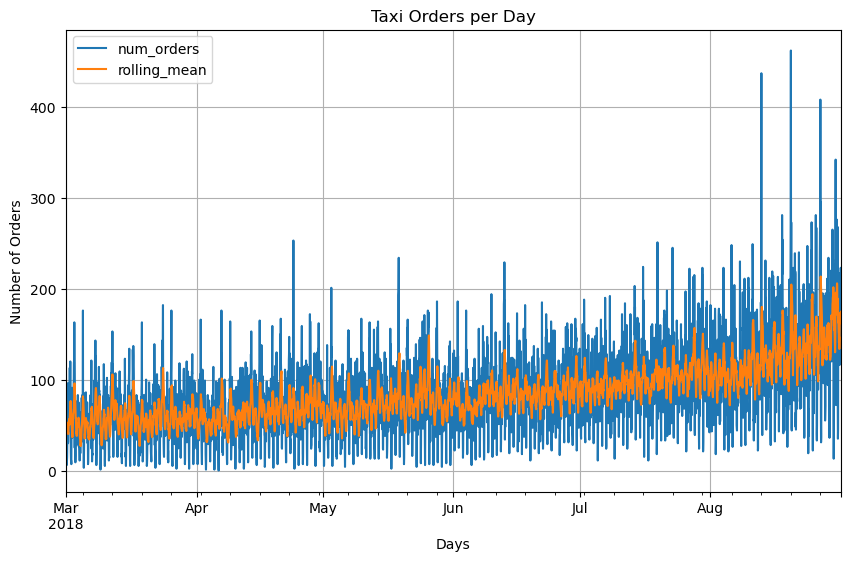

In [9]:
plot_orders_over_time(taxi_data_hourly)

The graph provides a comprehensive view of the taxi orders over time, with the rolling mean highlighting the general upward trend.

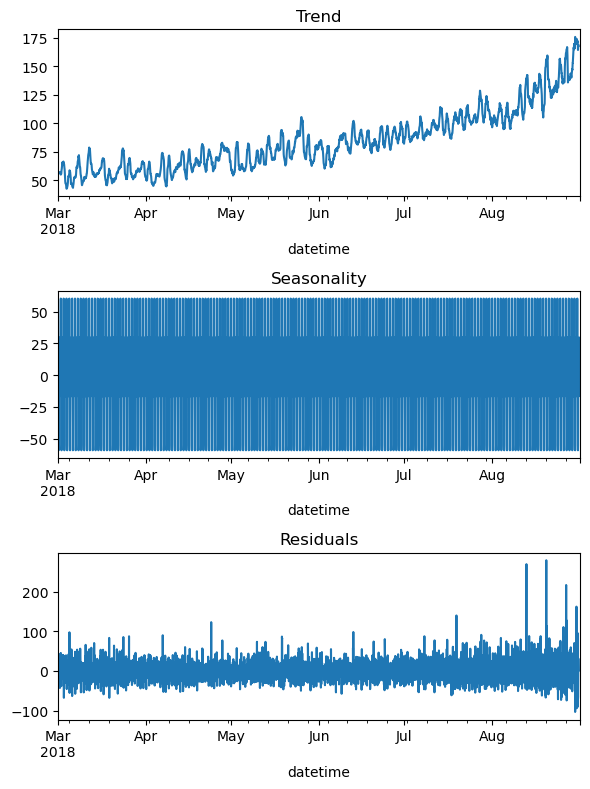

In [10]:
plot_time_series_decomposition(taxi_data_hourly)

The upward trend indicates growing demand, while the seasonal component suggests regular patterns in taxi orders, likely influenced by factors such as weekdays versus weekends or specific events. The residuals remaining close to zero suggest that the model adequately captures the primary dynamics of the data.

## 5-Training

With a clear understanding of what to expect, the data will now be organized for direct use by the models.

In [11]:
def create_lag_features(taxi_data, max_lag, rolling_mean_window):
    taxi_data['year'] = taxi_data.index.year
    taxi_data['month'] = taxi_data.index.month
    taxi_data['day'] = taxi_data.index.day
    taxi_data['day_of_week'] = taxi_data.index.dayofweek
    taxi_data['hour'] = taxi_data.index.hour
    
    for lag in range(1, max_lag + 1):
        taxi_data[f'lag_{lag}_hour'] = taxi_data['num_orders'].shift(lag)
    
    taxi_data['rolling_mean'] = taxi_data['num_orders'].shift(1).rolling(rolling_mean_window).mean()
    
    taxi_data.dropna(inplace=True)
    
    return taxi_data

The `create_lag_features` function enhances the `taxi_data` DataFrame by adding time-based features and lagged values of taxi orders. It extracts the year, month, day, day of the week, and hour from the DataFrame's datetime index. A loop creates lagged columns (e.g., `lag_1_hour`, `lag_2_hour`) for `num_orders` by shifting the values according to `max_lag`. Additionally, it calculates the rolling mean of `num_orders` over a specified window, storing it in a `rolling_mean` column. Finally, the function returns the modified DataFrame, which is useful for time series analysis.

In [12]:
taxi_data_features = create_lag_features(taxi_data_hourly.copy(), max_lag=24, rolling_mean_window=24)
taxi_data_features = taxi_data_features.dropna()

The code snippet first creates a new DataFrame, `taxi_data_features`, by calling the `create_lag_features` function on a copy of `taxi_data_hourly`. It specifies a `max_lag` of 24 and a `rolling_mean_window` of 24, adding lagged features and a rolling mean to the data. After that, it removes any rows with missing values using the `dropna()` method, ensuring the resulting DataFrame contains only complete observations for further analysis.

In [13]:
X = taxi_data_features.drop('num_orders', axis=1)
y = taxi_data_features['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
train_data, test_data = train_test_split(taxi_data_hourly, shuffle=False, test_size=0.1)

In this code snippet, the feature set `X` is created by dropping the `num_orders` column from the `taxi_data_features` DataFrame, while the target variable `y` is defined as the `num_orders` column. 

Next, the `train_test_split` function is used to split `X` and `y` into training and testing sets, with 10% of the data allocated for testing and without shuffling the order of the data (preserving the time series structure). The resulting sets are named `X_train`, `X_test`, `y_train`, and `y_test`. 

Additionally, a separate split is performed on the original `taxi_data_hourly` DataFrame, also allocating 10% for testing, resulting in `train_data` and `test_data`. This approach maintains the chronological order of the data, which is crucial for time series analysis.

## 6-Evaluation

Linear regression, a basic model, and AutoRegression, which is specifically designed for time series data, will now be executed and evaluated.

In [14]:
def train_autoregressive_model(train_data, test_data, max_lags=30):
    selected_model = ar_select_order(train_data, maxlag=max_lags)
    selected_lags = selected_model.ar_lags

    autoreg_model = AutoReg(train_data, lags=selected_lags, seasonal=True).fit()

    start_index = len(train_data)
    end_index = len(train_data) + len(test_data) - 1
    predictions = autoreg_model.predict(start=start_index, end=end_index, dynamic=False)
    
    return predictions, autoreg_model

The `train_autoregressive_model` function trains an autoregressive model using the provided training and testing datasets. First, it selects the optimal lags for the model using the `ar_select_order` function, based on a specified maximum number of lags (`max_lags`). 

Next, it initializes and fits the autoregressive model (`AutoReg`) on the training data, incorporating the selected lags and allowing for seasonality. The function then calculates the start and end indices for predictions, which correspond to the test dataset's range. Finally, it generates predictions using the fitted model and returns both the predictions and the autoregressive model object.

In [15]:
def train_decision_tree_model(X_train, X_test, y_train, y_test):
    dt_model = DecisionTreeRegressor(random_state=42)
    
    param_grid = {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_dt_model = grid_search.best_estimator_
    
    dt_predictions = best_dt_model.predict(X_test)
    dt_rmse = np.sqrt(mean_squared_error(y_test, dt_predictions))
    print(f'Decision Tree Regression RMSE: {dt_rmse:.2f}')
    print(f'Best Parameters: {grid_search.best_params_}')
    
    plt.plot(y_test.values, label='Test Data')
    plt.plot(dt_predictions, label='Decision Tree Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

This code implements a Decision Tree Regressor and optimizes its hyperparameters using a grid search approach. It first initializes a `DecisionTreeRegressor`, specifying a random state for reproducibility. A hyperparameter grid is defined with different values for `max_depth`, `min_samples_split`, and `min_samples_leaf`, allowing for various configurations of the decision tree model. The `GridSearchCV` function is then used to perform a grid search with 5-fold cross-validation, ensuring that the best combination of hyperparameters is selected based on the training data. The cross-validation process is parallelized using multiple jobs to speed up the computation.

Once the best hyperparameters are found, the optimized Decision Tree Regressor is trained on the full training dataset and used to predict the target values in the test set. The performance of the model is evaluated using the Root Mean Squared Error (RMSE) to measure prediction accuracy. The function prints the best hyperparameters, the RMSE of the test predictions, and generates a plot comparing the predicted and actual values from the test set. This visual representation helps assess the model's performance by showing how closely the predictions align with the actual data points.

In [16]:
def evaluate_autoreg_model(test_data, predictions):
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    print(f'AutoReg Model RMSE: {rmse:.2f}')
    
    plt.plot(test_data, label='Test Data')
    plt.plot(predictions, label='Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

The `evaluate_autoreg_model` function assesses the performance of an autoregressive model by comparing its predictions to the actual test data. It first calculates the Root Mean Squared Error (RMSE) between the test data and the predictions using `mean_squared_error` and `numpy`'s `sqrt` function, then prints the RMSE value formatted to two decimal places.

Next, the function visualizes the results by plotting the test data and the predictions on the same graph, allowing for easy comparison. It includes a legend to differentiate between the two lines and rotates the x-axis tick labels for better readability before displaying the plot.

In [17]:
def train_regression_model(X_train, X_test, y_train, y_test):
    regression_model = LinearRegression()
    regression_model.fit(X_train, y_train)

    regression_predictions = regression_model.predict(X_test)

    regression_rmse = np.sqrt(mean_squared_error(y_test, regression_predictions))
    print(f'Regression Model RMSE: {regression_rmse:.2f}')
    
    plt.plot(y_test.values, label='Test Data')
    plt.plot(regression_predictions, label='Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

The `train_regression_model` function trains a linear regression model using the provided training and testing datasets. First, it initializes the `LinearRegression` model and fits it to the training data (`X_train` and `y_train`). 

After training, it generates predictions on the test dataset (`X_test`). The function then evaluates the model's performance by calculating the Root Mean Squared Error (RMSE) between the actual test values (`y_test`) and the predicted values, printing the RMSE formatted to two decimal places.

AutoReg Model RMSE: 69.92


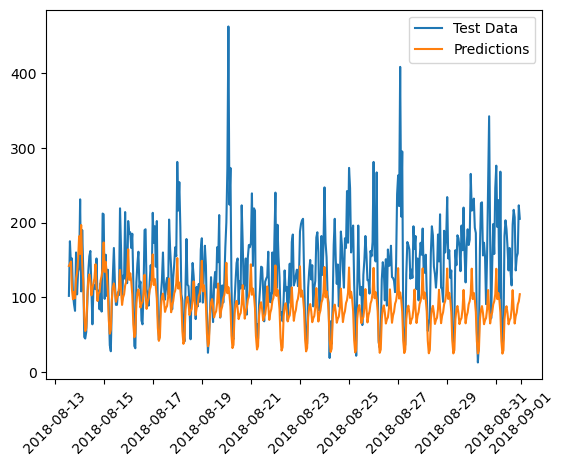

In [18]:
predictions, autoreg_model = train_autoregressive_model(train_data['num_orders'], test_data['num_orders'])
evaluate_autoreg_model(test_data['num_orders'], predictions)

The AutoReg model has an RMSE of 69.92, indicating an average difference of about 69.92 orders between the predicted and actual values. This RMSE score, along with its graph, will serve as a benchmark for evaluating other models and demonstrates a degree of reliability.

Regression Model RMSE: 45.75


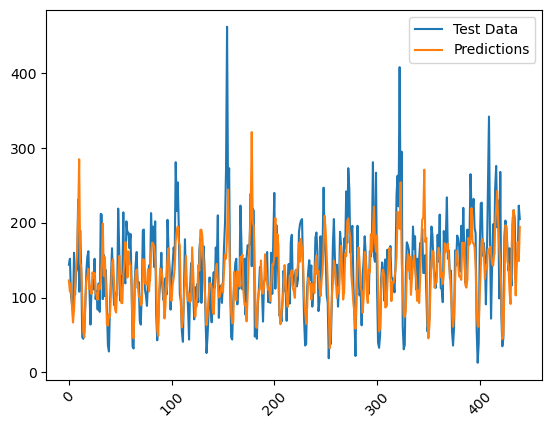

In [19]:
train_regression_model(X_train, X_test, y_train, y_test)

The linear regression model has an RMSE of 45.75, indicating a better match between the predicted values and the actual test data, in comparison to AutoReg. The RMSE and graph demonstrate the model's higher accuracy, showing less difference between the predictions and actual values.

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Decision Tree Regression RMSE: 53.56
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}


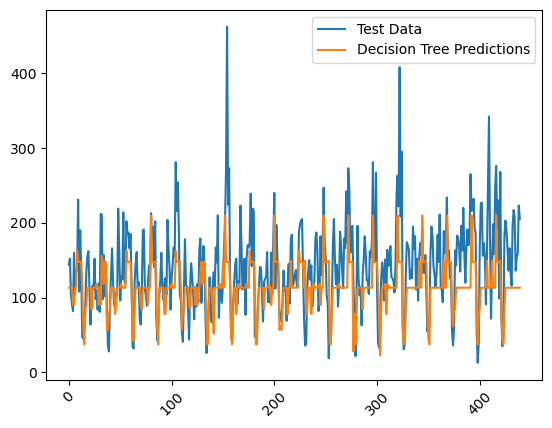

In [20]:
train_decision_tree_model(X_train, X_test, y_train, y_test)

The decision tree model has an RMSE of 53.56, showing less difference between the predictions and actual values. it doesn't outperform linear regression for this time series but does perform better than auto regression.

## 7-Conclusion

It's important to note that although AutoRegression is specifically designed for time series data, it does not necessarily outperform models that are not. Keeping this in mind, embracing a variety of options and maintaining an open-minded approach will enhance the quality of my work.